This code aims it simulate subsonic compressible flow in a curved duct. The fluid medium is air.

The simulation is set up such that the flow entering the duct has the following boundary conditions:

Mach Number = 0.5

Pressure  = 101325 Pascals

Temperature = 300 Kelvin

density = Pressure/(R*Temperature)

The air flowing into the duct is at an angle of 20 degrees therefore the x and y velocity components are computed as follows:

u = Mach Number * sqrt(gamma*R*Temperature) * cos(20)
v = Mach Number * sqrt(gamma*R*Temperature) * sin(20)

where gamma = 1.4

and R = 287.

The initial conditions are such that the air is initially stationary in the duct, therefore the velocity components are zero. The pressure, temperature and density of the air initially inside the duct are set to be the stagnation properties of the incoming flow and are computed using isentropic flow relations in the following link https://www.grc.nasa.gov/www/BGH/isentrop.html. 

Since this is not a uniform grid, the mapped grid solver is used.


2018-11-13 15:34:34,091 INFO CLAW: Solution 0 computed for time t=0.000000
2018-11-13 15:34:34,741 INFO CLAW: Solution 1 computed for time t=1.500000
2018-11-13 15:34:35,092 INFO CLAW: Solution 2 computed for time t=3.000000
2018-11-13 15:34:35,450 INFO CLAW: Solution 3 computed for time t=4.500000
2018-11-13 15:34:35,813 INFO CLAW: Solution 4 computed for time t=6.000000
2018-11-13 15:34:36,242 INFO CLAW: Solution 5 computed for time t=7.500000
2018-11-13 15:34:36,603 INFO CLAW: Solution 6 computed for time t=9.000000
2018-11-13 15:34:36,940 INFO CLAW: Solution 7 computed for time t=10.500000
2018-11-13 15:34:37,331 INFO CLAW: Solution 8 computed for time t=12.000000
2018-11-13 15:34:37,693 INFO CLAW: Solution 9 computed for time t=13.500000
2018-11-13 15:34:38,111 INFO CLAW: Solution 10 computed for time t=15.000000
2018-11-13 15:34:38,480 INFO CLAW: Solution 11 computed for time t=16.500000
2018-11-13 15:34:38,836 INFO CLAW: Solution 12 computed for time t=18.000000
2018-11-13 15:34

{'cflmax': 0.3754129004996418,
 'dtmax': 5.744716094813859,
 'dtmin': 3.7399524854534354,
 'numsteps': 41}

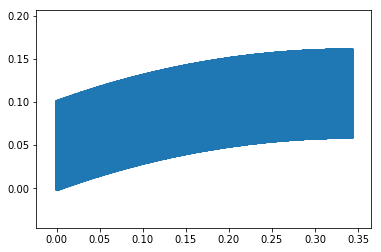

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from clawpack import pyclaw
from clawpack import riemann

import logging
logger = logging.getLogger('pyclaw')
logger.setLevel(logging.DEBUG)


# This function specifies the mapping to the physical domain
def mapc2p_(xc, yc):
    
    # The Transfinite_Interpolation function computes the coordinates of the interior nodes of a domain when it is given the ...
    # coordinates of the nodes at the boundaries
    def Transfinite_Interpolation(x, y, Nx, Ny):
        
        NP_ZEROS = np.zeros

        x1 = NP_ZEROS((Nx, Ny))
        y1 = NP_ZEROS((Nx, Ny))

        for i in range(0, Nx):
            for j in range(0, Ny):
                phi0 = float(i)/(Nx-1)
                phi1 = float(Nx-i-1)/(Nx-1)
                x1[i,j] = phi0*x[Nx-1, j] + phi1*x[0, j]
                y1[i,j] = phi0*y[Nx-1, j] + phi1*y[0, j]

        x2 = NP_ZEROS((Nx, Ny))
        y2 = NP_ZEROS((Nx, Ny))

        for i in range(0, Nx):
            for j in range(0, Ny):
                psi0 = float(j)/(Ny-1)
                psi1 = float(Ny-j-1)/(Ny-1)
                x2[i,j] = psi0*(x[i, Ny-1] - x1[i, Ny-1]) + psi1*(x[i,0] - x1[i,0])
                y2[i,j] = psi0*(y[i, Ny-1] - y1[i, Ny-1]) + psi1*(y[i,0] - y1[i,0])

        for i in range(0, Nx):
            for j in range(0, Ny):
                x[i,j] = x1[i,j] + x2[i,j]
                y[i,j] = y1[i,j] + y2[i,j]            
            
        return x, y
    
    # The Circular_Arc_Coordinates function computes the coordinates of a circular arc
    def Circular_Arc_Coordinates(x, y, R, theta, n):
        Cx = x + R*np.cos(np.pi/2 - theta)
        Cy = y - R*np.sin(np.pi/2 - theta)
    
        angles = np.linspace(theta, 0, n)
        x_arc_coordinates = np.zeros(n)
        y_arc_coordinates = np.zeros(n)
        for i in range(0, n):
            x_arc_coordinates[i] = Cx + R*np.cos(np.pi/2+angles[i])
            y_arc_coordinates[i] = Cy + R*np.sin(np.pi/2+angles[i])

        return x_arc_coordinates, y_arc_coordinates
    
    # Initiating the array that contains the coordinates of the cell centers 
    p_centers = []
   
    # Computing the number of cells in the x and y direction 
    mx, my = np.shape(xc)
    
    # Initiating empty arrays that contain the x and y coordinates of the nodes at the cell corners
    xp_edge_nodes = np.zeros((mx+1, my+1))
    yp_edge_nodes = np.zeros((mx+1, my+1))
    
    # Computing the coordinates of the corners nodes at the top wall of the duct
    xp_Top, yp_Top = Circular_Arc_Coordinates(0., 0.1, 1, np.radians(20), mx+1)
    
    # Computing the coordinates of the corners nodes at the bottom wall of the duct
    xp_Bottom, yp_Bottom = Circular_Arc_Coordinates(0., 0., 1, np.radians(20), mx+1)
 
    # Computing the coordinates of the corners nodes at the duct entry
    xp_Left = np.linspace(xp_Bottom[0], xp_Top[0], my+1)
    yp_Left = np.linspace(yp_Bottom[0], yp_Top[0], my+1)
    
    # Computing the coordinates of the corners nodes at the duct exit
    xp_Right = np.linspace(xp_Bottom[-1], xp_Top[-1], my+1)
    yp_Right = np.linspace(yp_Bottom[-1], yp_Top[-1], my+1)
    
    # Assigning the top wall, bottom wall, entry and exit coordinates to the arrays that contain the x and y coordinates of the 
    # nodes at the cell corners
    xp_edge_nodes[:,0] = xp_Bottom
    xp_edge_nodes[:,-1] = xp_Top
    xp_edge_nodes[0,:] = xp_Left
    xp_edge_nodes[-1,:] = xp_Right
    
    yp_edge_nodes[:,0] = yp_Bottom
    yp_edge_nodes[:,-1] = yp_Top
    yp_edge_nodes[0,:] = yp_Left
    yp_edge_nodes[-1,:] = yp_Right

    # Using the Transfinite_Interpolation function to obtain the interoir node coordinates. 
    XP_edge_nodes, YP_edge_nodes = Transfinite_Interpolation(xp_edge_nodes, yp_edge_nodes, mx+1, my+1)
    
    # Comptuting the coordinates of the cell centers based on the location of the corner codes 
    XP_centers = XP_edge_nodes[0:-1, :] + 0.5 * (XP_edge_nodes[1:, :] - XP_edge_nodes[0:-1, :])
    XP_Centers = 0.5 * (XP_centers[:, 0:-1] + XP_centers[:, 1:])
    
    YP_centers = YP_edge_nodes[:, 0:-1] + 0.5* (YP_edge_nodes[:, 1:] - YP_edge_nodes[:, 0:-1])
    YP_Centers = 0.5 * (YP_centers[0:-1, :] + YP_centers[1:, :,])
    
    # Assinging the coordinates of the cell centers tp the array that contains the coordinates of the cell centers
    p_centers.append(XP_Centers)
    p_centers.append(YP_Centers)
    
    
    return p_centers 

# auxilliary array
def setaux(state):

    # Physical Domain Nodes
    xp_nodes, yp_nodes = state.grid.p_nodes
    
    # Computation of the number of cell in the domain in the x and y directions
    nx, ny = np.shape(state.grid.p_centers[0])

    # Computation of the arrays consisting of the outward normal vectors on the left and the bottom of the cell
    
    # (Left Edge)
    n_LeftEdge = np.zeros((2, nx, ny))
    
    # Rotation Matrix: Rorates slope vector through an angle to obtain the outward pointing normal vector
    def Rotation_Matrix(angle):
        R = np.zeros((2,2))
        R[0,0] = np.cos(angle)
        R[0,1] = -np.sin(angle)
        R[1,0] = np.sin(angle)
        R[1,1] = np.cos(angle)
        return R
    
    alpha = np.deg2rad(90)
    Rot = Rotation_Matrix(alpha)

    for i in range(0, nx):
        for j in range(0, ny):
            # Computation of the tangent vector
            u = np.zeros((2,1))
            u[0] = xp_nodes[i, j+1] -  xp_nodes[i, j]
            u[1] = yp_nodes[i, j+1] -  yp_nodes[i, j]
            # Computation of the normal vector
            n = Rot @ u
            # Non dimensionalizing the normal vector
            n_unit = n/np.sqrt(n[0]**2 + n[1]**2)
            n_LeftEdge[0, i, j] = n_unit[0]
            n_LeftEdge[1, i, j] = n_unit[1]
    
    # (Bottom Edge)
    n_BottomEdge = np.zeros((2, nx, ny))
    # Rotation Matrix: Rorates slope vector through alpha to obtain the outward pointing normal vector
    beta = -np.deg2rad(90)
    Rot = Rotation_Matrix(beta)
    for i in range(0, nx):
        for j in range(0, ny):
            # Computation of the tangent vector
            u = np.zeros((2,1))
            u[0] = xp_nodes[i+1, j] -  xp_nodes[i ,j]
            u[1] = yp_nodes[i+1 , j] -  yp_nodes[i ,j]
            # Computation of the normal vector
            n = Rot @ u
            # Non dimensionalizing the normal vector
            n_unit = n/np.sqrt(n[0]**2 + n[1]**2)
            n_BottomEdge[0, i, j] = n_unit[0]
            n_BottomEdge[1, i, j] = n_unit[1]
            
    # Computation of the Length Ratios at the left and bottom of the cells as well as cappacity (area ratio)
    gamma_LeftEdge = np.zeros((nx, ny))
    gamma_BottomEdge = np.zeros((nx, ny))
    capa = np.zeros((nx, ny))
    
    # delta in the computational domain
    dx, dy = state.grid.delta
    
    for i in range(0, nx):
        for j in range(0, ny):
            # Computation of the length of the cell on the left edge of the cell
            hp = np.sqrt((yp_nodes[i, j+1]- yp_nodes[i, j])**2 + (xp_nodes[i, j+1]- xp_nodes[i, j])**2 )
            # Computation of the length ratio of the cell on the left edge of the cell
            gamma_LeftEdge[i, j] = hp/dy
            # Computation of the length of the cell on the bottom edge of the cell
            wp = np.sqrt((yp_nodes[i+1, j]- yp_nodes[i, j])**2 + (xp_nodes[i+1, j]- xp_nodes[i, j])**2 )
            # Computation of the length ratio of the cell on the bottom edge of the cell
            gamma_BottomEdge[i, j] = wp/dx
            # Computation of the area of the cell in the physical domain (i.e. computation of the area on a irregular quadrilateral)
            a = np.sqrt((yp_nodes[i+1, j+1]- yp_nodes[i, j+1])**2 + (xp_nodes[i+1, j+1]- xp_nodes[i, j+1])**2)
            b = np.sqrt((yp_nodes[i+1, j+1]- yp_nodes[i+1, j])**2 + (xp_nodes[i+1, j+1]- xp_nodes[i+1, j])**2)
            c = np.sqrt((yp_nodes[i+1, j]- yp_nodes[i, j])**2 + (xp_nodes[i+1, j]- xp_nodes[i, j])**2)
            d = np.sqrt((yp_nodes[i, j+1]- yp_nodes[i, j])**2 + (xp_nodes[i, j+1]- xp_nodes[i, j])**2)
            s = 1./2.*(a+b+c+d)
            A_p = np.sqrt((s-a)*(s-b)*(s-c)*(s-d))
            # Computation of the capacity
            capa[i, j] = (A_p)/(dx*dy)

    # Populating the auxillary matrix with the computed values as per pg 532 of 'Finite Volume Methods for Hyperbolic Problems'
    aux = np.zeros((7, nx, ny))
    aux[0, :, :] = n_LeftEdge[0, :, :]
    aux[1, :, :] = n_LeftEdge[1, :, :]
    aux[2, :, :] = gamma_LeftEdge
    aux[3, :, :] = n_BottomEdge[0, :, :]
    aux[4, :, :] = n_BottomEdge[1, :, :]
    aux[5, :, :] = gamma_BottomEdge
    aux[6, :, :] = capa
    
    return aux


# Boundary condition that is specifying the continuous flow of air coming into the duct
def incoming_flow(state, dim, t, qbc, auxbc, num_ghost):
    gamma = 1.4
    R = 287.
    
    # Mach Number
    M = 0.5  
    
    # Pressure (Pascals)
    P = 101325.
    
    # Temperature (Kelvin)
    T = 300.  
    
    # Density (kg/m^3)
    rho = P/(R*T)    
    
    # x-component of velocity (m/s)
    u = M * np.sqrt(gamma*R*T) * np.cos(np.radians(20))  
    
    # y-component of velocity (m/s)
    v = M * np.sqrt(gamma*R*T) * np.sin(np.radians(20))  

    for i in range(num_ghost):
        qbc[0,i,...] = rho
        qbc[1,i,...] = rho*u
        qbc[2,i,...] = rho*v
        qbc[3,i,...] = P/(gamma-1.) + 0.5*rho*(u**2 + v**2)
        
        
# initial conditions. Assuming flow is initially stationary in the duct. The stagnation properties of the incoming flow are used to
# compute the initial conditions since air is stationary in the duct
def qinit(state):
    
    gamma = 1.4
    R = 287.
    # Incoming Flow Properties
    
    # Mach Number
    M = 0.5 
    
    # Pressure (Pascals)
    P = 101325.       
    
    # Temperature (Kelvin)
    T = 300.  
    
    # Density (kg/m^3)
    rho = P/(R*T)  
    

    # Stagnation properties
    
    # Computation of stagnation temperature based in the incoming flow properties T and M
    T0 = T*(1. + ((gamma-1.)/2.)*M**2)   
    
    # Computation of stagnation pressure based in the incoming flow properties P and M
    P0 = P*(1. + ((gamma-1.)/2.)*M**2)**(gamma/(gamma-1.))   
    
    # Computation of stagnation density based in the incoming flow properties rho and M
    rho0 = rho*(1. + ((gamma-1.)/2.)*M**2)**(1./(gamma-1.))
    
    # Stagnation conditions mean that air is stationary therefore the velocity components are zero
    u0 = 0.
    v0 = 0.
    
    state.q[0,...] = rho0 
    state.q[1,...] = rho0*u0
    state.q[2,...] = rho0*v0
    state.q[3,...] = P0/(gamma-1.) + 0.5*rho0*(u0**2 + v0**2)

    
# Creating the computational domain
nx = 1000
ny = 475
x = pyclaw.Dimension(0, float(nx), nx, name='x')
y = pyclaw.Dimension(0, float(ny), ny, name='y')
domain = pyclaw.Domain([x, y])
# Apply mapping
domain.grid.mapc2p = mapc2p_

# Selecting the solver 
solver = pyclaw.ClawSolver2D(riemann.euler_mapgrid_2D)

# Assigning the number of ghost sells in this solver to the grid 
domain.grid.num_ghost = solver.num_ghost

# Plotting the physical domain
X, Y = domain.grid.p_centers
plt.scatter(X, Y, s = 15)
plt.axis('equal')

# Applying the boundary conditions to the domain. 
# The top and bottom boundary conditions are walls
# The left boundary condition is the incoming flow function
# The exit conditions are extrapolated from internal domain
solver.user_bc_lower = incoming_flow
solver.bc_lower[0] = pyclaw.BC.custom 
solver.bc_upper[0] = pyclaw.BC.extrap
solver.bc_lower[1] = pyclaw.BC.wall
solver.bc_upper[1] = pyclaw.BC.wall

# Applying auxillary boundary conditions
solver.aux_bc_lower[0] = pyclaw.BC.extrap
solver.aux_bc_upper[0] = pyclaw.BC.extrap
solver.aux_bc_lower[1] = pyclaw.BC.wall
solver.aux_bc_upper[1] = pyclaw.BC.wall

# The number of variables in the auxilliary array
num_aux = 7
# Initiating the state
state = pyclaw.State(domain, solver.num_eqn, num_aux)
state.problem_data['gamma'] = 1.4
# Assignign the auxilliary array
state.aux[:,:,:] = setaux(state)
# Initiating the initial conditions 
qinit(state)

# Initiating the controller and the time steps
claw = pyclaw.Controller()
claw.cfl_desired = 0.9
claw.cfl_max = 1.0

claw.dt_variable = True
claw.dt_initial = 1e-10

claw.num_output_times = 2*10*(2)
claw.tfinal = 60.


claw.keep_copy = True
claw.output_format = None

claw.solution = pyclaw.Solution(state, domain)
claw.solver = solver

claw.run()




[[1.72422840e-01 2.23447797e-01 2.32617102e-01 ... 2.31981070e-01
  2.22799611e-01 2.20575071e-01]
 [2.94888880e-03 2.03457396e-03 3.29801698e-03 ... 4.37616406e-03
  8.07707366e-03 1.05494002e-02]
 [4.75482538e-04 1.98007581e-04 2.38901989e-04 ... 3.27971367e-04
  5.25165347e-04 8.05498865e-04]
 ...
 [3.04278338e-04 1.29096461e-04 1.88073926e-06 ... 1.30718923e-06
  1.30446904e-06 1.29995931e-06]
 [3.04241260e-04 1.29159352e-04 1.88802428e-06 ... 1.30564425e-06
  1.30276460e-06 1.29922843e-06]
 [3.04220142e-04 1.29231256e-04 1.89486665e-06 ... 1.30425204e-06
  1.30117176e-06 1.29862493e-06]]


(0.0001640177170928181,
 0.34184561040401384,
 0.0001649283081004601,
 0.16020208559445526)

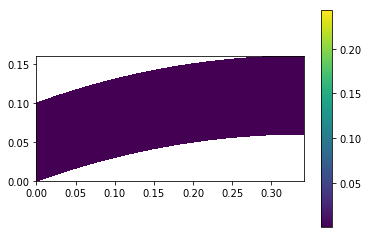

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
gamma = 1.4
R = 287.

frame = claw.frames[20]
rho = frame.q[0,:,:]
u = frame.q[1,:,:]/frame.q[0,:,:]
v = frame.q[2,:,:]/frame.q[0,:,:]
p = (gamma-1.)*(frame.q[3,:,:] - 0.5*rho*(u**2 + v**2))
T = p/(rho*R)
M = np.sqrt(u**2+v**2)/np.sqrt(gamma*R*T)
print(M)

x, y = frame.state.grid.p_centers

plt.pcolormesh(x, y, M)
plt.colorbar()
plt.axis('image')
#plt.show()